# Load in Packages

In [1]:
import numpy as np
import matplotlib as mpl
#mpl.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.colors import PowerNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter
from skimage.draw import disk
from scipy.optimize import curve_fit
from scipy import signal
from scipy.fft import fft, fftshift
#from lmfit import Parameters, minimize, report_fit
from obspy.imaging.cm import viridis_white
import cmocean
import xarray as xr
from math import nan
import multiprocessing

import sys, os
sys.path.append(os.path.abspath("R:\Lawson\mpes-analysis"))  # or full path to project

from Loader import DataLoader
from Main import main
from Manager import DataHandler, FigureHandler, PlotHandler, ValueHandler, SliderManager, EventHandler, CheckButtonManager, ClickButtonManager
import mpes
from mpes import cmap_LTL, cmap_LTL2
%load_ext autoreload
%autoreload 2

c:\Users\lloyd\Anaconda3\lib\site-packages\obspy\core\util\base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Load the Data
### Specify Filename and Path. Load the Data

In [4]:
# Specify datapath, filename, and [Energy, Delay] offsets to load.

data_path = 'R:\Lawson\Data\metis'
#data_path = '/Users/lawsonlloyd/Desktop/Data/metis'

# CrSBr
filename, offsets = 'Scan162_RT_120x120x115x50_binned.h5', [0.8467, -120]
#filename, offsets = 'Scan162_RT_120x120x115x51_rebinned_newECAL.h5', [0.035, 0]
#filename, offsets = 'Scan177_120K_120x120x115_binned.h5', [0.363, 0]

filename, offsets = 'Scan186_120K_Static_120x120x200_binned.h5', [0.039, 0]
filename, offsets = 'Scan188_120K_120x120x115x77_binned.h5', [0.5660, -105]
#filename, offsets = 'Scan163_120K_101x101x131x77_binned_v3.h5',  [0, 0]

#filename, offsets = 'Scan0804_30K_Pprobe_Spump_binned.h5', [.5047, -102]
# filename, offsets = 'Scan1042_binned.h5', [-0.4, 0]
# filename, offsets = 'Scan1052_binned.h5', [0, 0]
# filename, offsets = 'Scan1058_binned.h5', [-2, 0]
# filename, offsets = 'Scan1060_binned.h5', [-4, 0]
# filename, offsets = 'Scan1062_binned.h5', [-5.5, 0]
# filename, offsets = 'Scan1063_binned.h5', [-4.5, 0]
# filename, offsets = 'Scan1064_binned.h5', [-4.75, 0]
# filename, offsets = 'Scan1076_binned.h5', [-0.4, 0]
#filename, offsets = 'Scan1095_binned.h5', [0, -55]
# filename, offsets = 'Scan1097_binned.h5', [0, 0]

# NiI2
#filename, offsets = 'Scan1192_RT_NiI2_121x121x164x66_binned.h5', [.3, 0]
#filename, offsets = 'Scan1205_RT_NiI2_121x121x164_binned.h5', [-.6, 0]
#filename, offsets = 'Scan1206_RT_NiI2_121x121x164_binned.h5', [0, 0]
#filename, offsets = 'Scan1207_RT_NiI2_201x201x176_binned.h5', [0.3, 0]
#filename, offsets = 'Scan1209_RT_NiI2_201x201x176_binned.h5', [0, 0]
#filename, offsets = 'Scan1210_RT_NiI2_xuvpolscan_121x121x139x73_binned.h5', [0, 0]
#filename, offsets = 'Scan1109_binned.h5', [0, 0]
#filename, offsets = 'Scan1095_binned.h5', [0, 0]
filename, offsets = 'Scan1216_RT_NiI2_101x101x176x66_binned.h5', [0.3, 0]
filename, offsets = 'Scan1226_NiI2_45K_101x101x176x66_chargingCorrected_v1_binned.h5', [0, 0]
#filename, offsets = 'Scan1227_chargingCorrected_v1_binned.h5', [0, 0]

filename, offsets = 'Scan31_21K_60%_Pprobe_Spump_binned.h5', [-0.5, -50]
filename, offsets = 'Scan2667_chargingCorrected_binned.h5', [0, 0]

#  Load the Data
data_loader = DataLoader(data_path + '//' + filename, offsets = offsets)
I = data_loader.load()

The data shape is: (101, 101, 120, 70)
"R:\Lawson\Data\metis//Scan2667_chargingCorrected_binned.h5" has been loaded! Happy Analysis...


### Generate Normalized and Difference Data


In [ ]:
# Truncate and Normalize Data, if desired.
#I = I.loc[{"delay":slice(-400,1000)}]

# Normalize Each Time Step to the Total Volume Counts, if desired
I = I / I.sum(dim=('kx','ky','E'))
I = I/np.max(I)

# Generate Difference Data (Pos - Neg Delay Times), if desired.
if "delay" in I.dims:
    I_res = I[:, :, :,1:-1]
    I_res = I_res/np.max(I_res)
    I_diff = I_res - I_res.loc[{"delay":slice(-250,-100)}].mean(dim="delay")
    I_diff = I_diff/np.max(I_diff)
else:
    I_res = I/np.max(I)


# Analysis and Visualization
### Launch Interactive GUI

In [208]:
%matplotlib qt

#main(I_res, title='TEST')

# run the following in terminal:
# 
# start python launch_gui_v0.py (Windows)
# or
# python launch_gui_v0.py & (mac)

### Overview Plot

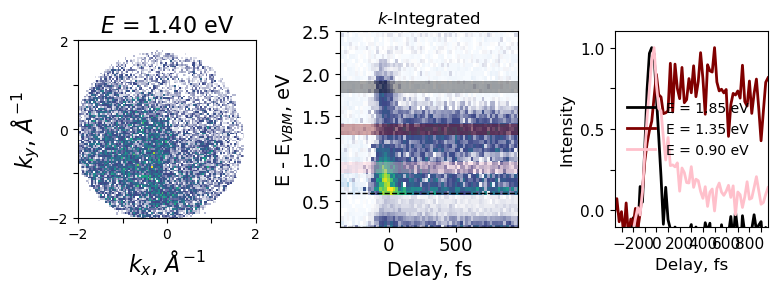

In [28]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios':[1]})
fig.set_size_inches(8, 3, forward=False)
axs = axs.flatten()

# Plot momentum map
mpes.plot_momentum_maps(
    I_res, E=1.4, E_int=.2, delays=500, delay_int=1000,
    fig = fig, ax = axs[0],
    cmap=cmap_LTL,
    panel_labels=False, fontsize=16,
    nrows=2, figsize=(8, 6)
)

# Plot waterfall
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
mpes.plot_waterfall(
    I_res, kx, kx_int, ky, ky_int,
    fig = fig, ax = axs[1], subtract_neg = True,
    energy_limits=[0.2, 2.5], E_enhance = .6
)

# Plot time traces
E, E_int = [1.85, 1.35, 0.9], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
neg_delays = [-250, -100]
colors = ['black', 'maroon', 'pink']

mpes.plot_time_traces(
    I_res, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace=True, subtract_neg=True, neg_delays=neg_delays,
    fig = fig, ax = axs[2],
    colors = colors,
    fontsize=12
)
axs[2].set_ylim(-0.1, 1.1)
axs[2].set_aspect(1400)

for i in np.arange(len(E)):
    mpes.add_rect(500, 2000, E[i], E_int, axs[1], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)

#mpes.save_figure(fig, name = f'test', image_format = 'pdf')

fig.tight_layout()

### Plot Momentum Maps at Constant Energy

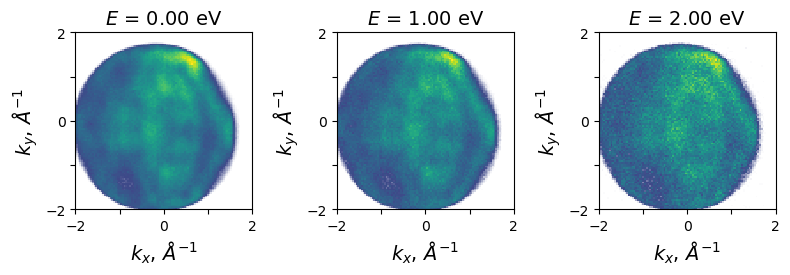

In [200]:
%matplotlib inline
cmap_plot = cmap_LTL

E, E_int = [0, 1, 2], .15
#delays, delay_int = 500, 1000

fig, ax, im = mpes.plot_momentum_maps(
    I_res, E=E, E_int=E_int, delays=None, delay_int=200,
    cmap=cmap_LTL, scale=[0, 1], 
    fontsize=14, figsize=(8, 6), colorbar=False, panel_labels = False
)

mm_1 = mpes.get_momentum_map(I_res, E=1.2, E_int=0.1, delay=500, delay_int=200)
mm_2 = mpes.get_momentum_map(I_res, E=1.2, E_int=0.1, delay=-200, delay_int=200)

mm_1 = mm_1 / np.max(mm_1)
mm_2 = mm_2 / np.max(mm_2)

mm_diff = mm_1 - mm_2
mm_diff = mm_diff / np.max(np.abs(mm_diff))
#mpes.overlay_bz('rectangular', 3.508, 4.763, ax[0], 'black', rotation_deg = 0, repeat = 0)
#mpes.overlay_bz('hexagonal', 5.8, 5.8, ax[0], 'black', repeat = 2, rotation_deg = 90)
#mpes.save_figure(fig, name = f'scan186', image_format = 'svg')

In [192]:
edc_1 = mpes.get_edc(I_res, 0, 0, 4, 4, delays=600, delay_int=350)
edc_2 = mpes.get_edc(I_res, 0, 0, 4, 4, delays=-250, delay_int=200)

mpes.get_edc()
edc_1 = edc_1 / np.max(edc_1.loc[{"E":slice(0.5,3)}])
edc_2 = edc_2 / np.max(edc_2.loc[{"E":slice(0.5,3)}])

edc_diff = edc_1 - edc_2
edc_diff = edc_diff /np.max(edc_diff.loc[{"E":slice(0.5,3)}])

edc_1.plot(color='green')
edc_2.plot(color='grey')
plt.xlim(0.5,2.5)
plt.ylim(0.001,1)
plt.yscale('log')
ax = plt.twinx()
edc_diff.plot(ax=ax)
ax.set_ylim(-1,1)

plt.axhline(0, linestyle='dashed')

TypeError: get_edc() missing 5 required positional arguments: 'I_res', 'kx', 'ky', 'kx_int', and 'ky_int'

### Waterfall Plot: Momentum-Integrated Dynamics

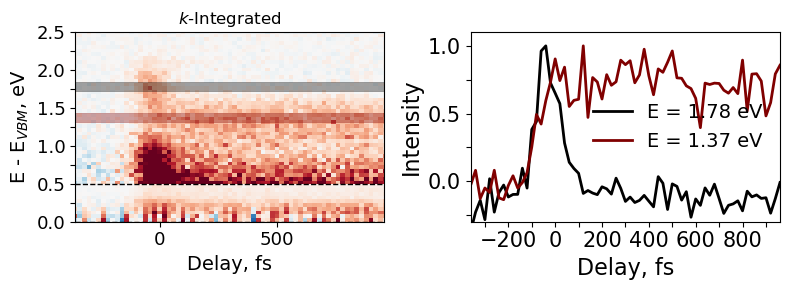

: 

In [ ]:
# Plot waterfall
%matplotlib inline

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3, forward=False)
axs.flatten()

# Plot waterfall
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
neg_delays = [-400, -120]
mpes.plot_waterfall(
    I_res, kx, kx_int, ky, ky_int,
    fig = fig, ax = axs[0], subtract_neg = True, neg_delays = neg_delays, cmap='RdBu_r', scale=[-0.5, 0.5],
    energy_limits=[0.0, 2.5], E_enhance = .5
)
# Plot time traces
E, E_int = [1.78, 1.37], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
neg_delays = [-250, -100]
colors = ['black', 'maroon', 'pink']

mpes.plot_time_traces(
    I_res, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace=True, subtract_neg=True, neg_delays=neg_delays,
    fig = fig, ax = axs[1],
    colors = colors,
    fontsize=16
)

axs[1].set_ylim(-0.3, 1.1)
for i in np.arange(len(E)):
   mpes.add_rect(500, 2000, E[i], E_int, axs[0], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)


### Plot & Fit Time Traces


Fit Results for model: biexp
----------------------------------------
A          =     1.1932 ±  0.0614
tau_decay1 =   166.6471 ± 14.9302
B          =     0.1124 ±  0.0712
tau_decay2 =  2073.6916 ± 3225.9143
----------------------------------------

Fit Results for model: biexp
----------------------------------------
A          =     0.9356 ±  0.1137
tau_decay1 =   225.8940 ± 42.1735
B          =     0.3112 ±  0.1289
tau_decay2 = 10000.0000 ± 43092.2069
----------------------------------------


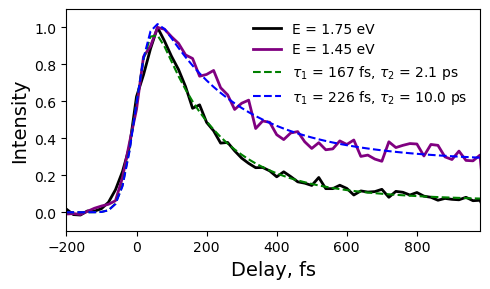

In [159]:
E, E_int = [1.75, 1.45], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration

norm_trace = True
subtract_neg = True
neg_delays = [-280, -100]

convolve = True
fwhm_IRF, sigma_IRF = 80, fwhm_IRF/2.355

fig, axs = plt.subplots()
fig.set_size_inches(5, 3, forward=False)
#axs = axs.flatten()

mpes.plot_time_traces(
    I, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace, subtract_neg, neg_delays,
    fig = fig, ax = axs,
    colors = ['black', 'purple'],
    fontsize=14
)

### Do a Fitting: Choose model (input as string, e.g. 'monoexp') and input fit parameters (p0, bounds etc.)
delay_limits = (-200, 980)
delay_axis_1 = I.delay.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

# Curve 1
time_trace = mpes.get_time_trace(I, E[0], E_int, (kx, ky), (kx_int, ky_int), norm_trace = True, subtract_neg = True, neg_delays = neg_delays)
time_trace = time_trace.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

model = 'biexp'
p0 = [1, 100, 1, 1000]
lower_bounds, upper_bounds = (0, 0, 0, 0), (10, 5000, 10, 20000)
#model = 'monoexp'
#p0 = [1, 100]
#lower_bounds, upper_bounds = (0, 0), (10, 5000)
popt1, pcov, fit_curve_1 = mpes.fit_time_trace(model, delay_axis_1, time_trace, p0, [lower_bounds, upper_bounds], convolve = convolve, sigma_IRF = sigma_IRF)
params_ex, label_ex = mpes.print_fit_results(model, popt1, pcov)

delay_limits = (-200, 980)
delay_axis_2 = I.delay.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

# Curve 2
time_trace = mpes.get_time_trace(I, E[1], E_int, (kx, ky), (kx_int, ky_int), norm_trace = True, subtract_neg = True, neg_delays = neg_delays)
time_trace = time_trace.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

#model = 'exp_rise_monoexp_decay'
#p0 = [2, 10, 120] #C, tau_rise, tau_decay1)
#lower_bounds, upper_bounds = (0, 0, 0), (10, 2000, 10000)
model = 'biexp'
p0 = [1, 100, 1, 3000]
lower_bounds, upper_bounds = (0, 0, 0, 0), (10, 5000, 10, 10000)
#model = 'monoexp'
#p0 = [1, 100]
#lower_bounds, upper_bounds = (0, 0), (10, 5000)
popt2, pcov, fit_curve_2 = mpes.fit_time_trace(model, delay_axis_2, time_trace, p0, [lower_bounds, upper_bounds], convolve = convolve, sigma_IRF = sigma_IRF)
params_cbm, label_cbm = mpes.print_fit_results(model, popt2, pcov)

#conv_model = mpes.make_convolved_model(mpes.exp_rise_monoexp_decay, delay_axis, 40)
#init_curve = conv_model(delay_axis, *p0)

# Plot Fits
axs.plot(delay_axis_1, fit_curve_1, linestyle = 'dashed', color = 'green', label = label_ex)
axs.plot(delay_axis_2, fit_curve_2, linestyle = 'dashed', color = 'blue', label = label_cbm)
axs.legend(frameon=False)
axs.set_ylim(-0.1,1.1)
axs.set_xlim(-200,delay_limits[1])
fig.tight_layout()

### Plot Energy vs Momentum

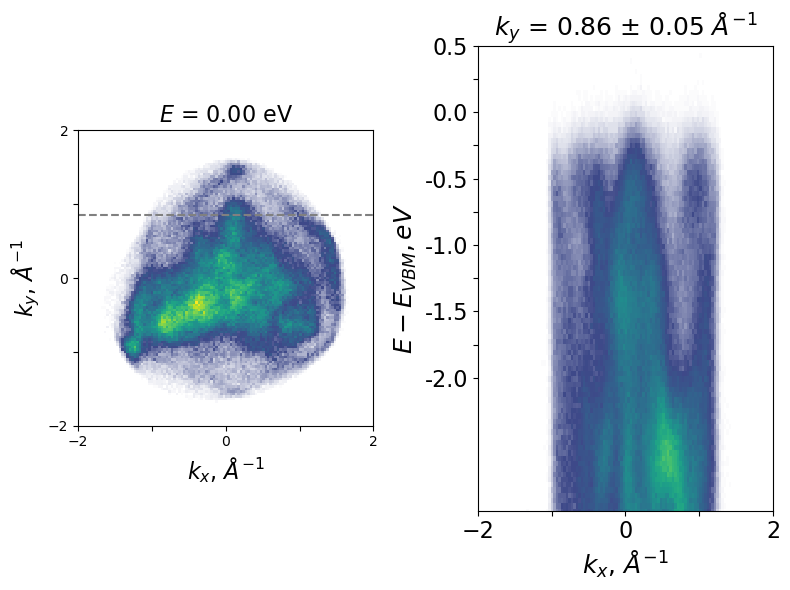

In [165]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(8, 6, forward=False)
axs = axs.flatten()

# Plot momentum map
mpes.plot_momentum_maps(
    I_res, E=0, E_int=0.2, delays=100, delay_int=100,
    fig = fig, ax = axs[0],
    cmap=cmap_plot,
    panel_labels=False, fontsize=16,
    nrows=2, figsize=(12, 12)
)

# # Plot k - E (arbitrary Cut)
# k_start, k_end = (-1.5, 1), (1.6, -.7)
# #I_cut, k_vals, E_vals = mpes.get_k_cut(I_res.mean(dim="delay"), k_start=k_start, k_end=k_end)
# I_cut, k_vals, E_vals = mpes.get_k_cut(I_res, k_start=k_start, k_end=k_end)

# axs[0].plot(k_start[0], k_start[1], 'ro')
# axs[0].plot(k_end[0], k_end[1], 'ro')
# axs[0].plot([k_start[0], k_end[0]], [k_start[1], k_end[1]], color = 'red', linestyle = 'dashed')

# axs[1].pcolormesh(k_vals, E_vals, I_cut, shading='auto', cmap=cmap_LTL)
# axs[1].set_xlabel("k along cut ($\AA^{-1}$)")
# axs[1].set_ylabel("Energy (eV)")
# axs[1].set_title("E vs k slice", color = 'red')
# axs[1].set_ylim(-6,1)
# axs[1].set_aspect(1)

# # Plot k - E (arbitrary Cut)
# k_start, k_end = (-1.5, 0.9), (1.5, 0.9)
# #I_cut, k_vals, E_vals = mpes.get_k_cut(I_res.mean(dim="delay"), k_start=k_start, k_end=k_end)
# I_cut, k_vals, E_vals = mpes.get_k_cut(I_res, k_start=k_start, k_end=k_end)

# axs[0].plot(k_start[0], k_start[1], 'bo')
# axs[0].plot(k_end[0], k_end[1], 'bo')
# axs[0].plot([k_start[0], k_end[0]], [k_start[1], k_end[1]], color = 'blue', linestyle = 'dashed')

# axs[2].pcolormesh(k_vals, E_vals, I_cut, shading='auto', cmap=cmap_LTL)
# axs[2].set_xlabel("k along cut ($\AA^{-1}$)")
# axs[2].set_ylabel("Energy (eV)")
# axs[2].set_title("E vs k slice", color = 'blue')
# axs[2].set_ylim(-6,1)
# axs[2].set_aspect(1)

# Plot kx-E frame
(kx, ky), (kx_int, ky_int) = (0, .86), (.1, 0.1) # Central (kx, ky) point and k-integration
mpes.plot_kx_frame(
    I_res, ky, ky_int,
    E_enhance = 1,
    subtract_neg=True, neg_delays=[-500,-100],
    fig = fig, ax = axs[1],
    cmap = cmap_plot, scale=[0,1], energy_limits=[-3,0.5]
)
axs[0].axhline(ky, linestyle = 'dashed', color = 'grey')
# # Plot ky-E frame
# (kx, ky), (kx_int, ky_int) = (0, 0), (0.2, 0.2) # Central (kx, ky) point and k-integration
# mpes.plot_ky_frame(
#     I_res, ky, ky_int,
#     subtract_neg=True, neg_delays=[-500,-100],
#     fig = fig, ax = axs[1],
#     cmap = cmap_plot, scale=[0,1], energy_limits=[-3,.5]
#     )

fig.tight_layout()

# Data Treatment
### Define E = 0 wrt VBM

E_VBM = 0.004 +- 0.002 eV


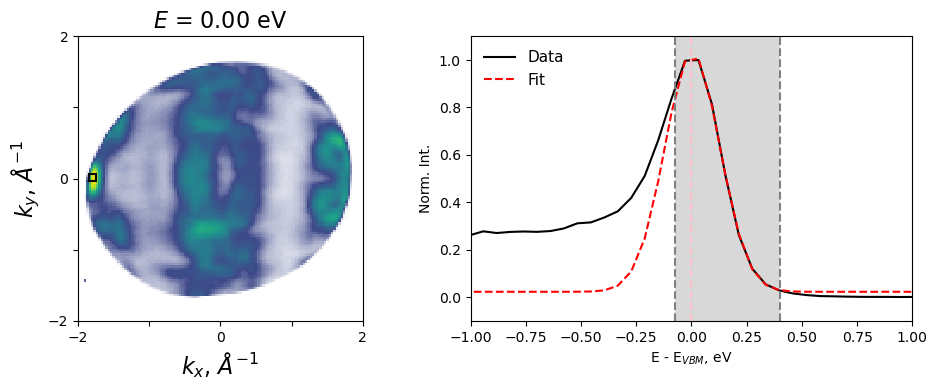

In [134]:
#%% Define E = 0 wrt VBM

%matplotlib inline

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[1]})
fig.set_size_inches(10, 4, forward=False)
ax = ax.flatten()

figure_file_name = 'vbm'
save_figure = False

### Plot EDCs at GAMMA vs time

(kx, ky), k_int = (-1.8, 0.01), 0.1
#(kx, ky), k_int = (0, 1.6), 0.1

delay, delay_int = -150, 200

edc_gamma = mpes.get_edc(I_res, kx, ky, (k_int, k_int), delay, delay_int)
edc_gamma = edc_gamma/np.max(edc_gamma)

mpes.plot_momentum_maps(
    I_res, E=0, E_int=.1, delays=500, delay_int=1000,
    fig = fig, ax = ax[0],
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(8, 6), colorbar=False, panel_labels = False
)
    
energy_window = [-0.075, 0.4]
p0 = [1, .02, 0.4, 0] # Fitting params initial guess [amp, center, width, offset]

mpes.find_E0(edc_gamma, energy_window, p0, fig, ax)

# cbar_ax = fig.add_axes([.51, 0.275, 0.025, 0.5])
rect = (Rectangle((kx-k_int/2, ky-k_int/2), k_int, k_int, linewidth=1.5,\
                         edgecolor='k', facecolor='None'))

rect1 = (Rectangle((energy_window[0], -.5), (energy_window[1]-energy_window[0]), 2, linewidth=1.5,\
                         edgecolor='none', facecolor='grey', alpha=0.3))

fig.axes[0].add_patch(rect)
fig.axes[1].add_patch(rect1)
ax[1].set_ylim(-0.1,1.1)
ax[1].axvline(energy_window[0], color = 'grey', linestyle = 'dashed')
ax[1].axvline(energy_window[1], color = 'grey', linestyle = 'dashed')
ax[1].axvline(0, color = 'pink', linestyle = 'dashed')


### Define t0 from Signal Rise


t0 = -2.4 +/- 2.3 fs
width = 56.3 +/- 4.6 fs


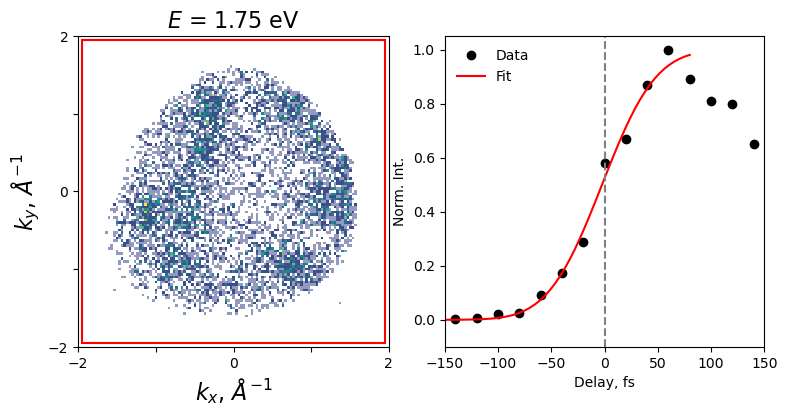

In [111]:
#%% Define t0 from Exciton Rise

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[1]})
fig.set_size_inches(8, 4, forward=False)
ax = ax.flatten()

figure_file_name = 'define_t0'
save_figure = False

### Plot EDCs at GAMMA vs time

(kx, ky), (kx_int, ky_int) = (0, 0), (3.9, 3.9)
#(kx, ky), (kx_int, ky_int) = (0, .7), (1.5, 0.5)
E, E_int = 1.75, 0.1
delay_limits = [-150, 80]

mpes.plot_momentum_maps(
    I_res, E=E, E_int=E_int, delays=200, delay_int=700,
    fig = fig, ax = ax[0],
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(8, 6), colorbar=False, panel_labels = False
)
    
rect = (Rectangle((kx-kx_int/2, ky-ky_int/2), kx_int, ky_int, linewidth=1.5,\
                         edgecolor='red', facecolor='None'))
fig.axes[0].add_patch(rect)

trace_ex = mpes.get_time_trace(I_res, E, E_int, (kx, ky), (kx_int, ky_int),  norm_trace = True, subtract_neg = True, neg_delays = (-350, -100))
mpes.find_t0(trace_ex, delay_limits, fig=fig, ax=ax)

if save_figure is True:
    mpes.save_figure(fig, name = f'test', image_format = 'pdf')